### **Introduction**
This notebook is for peak, firing rate, amplitude, and synchronization index analyzing on Calcium imaging traces.

*You have to export the ROI traces in inscopix analyze software or using caiman code. Obtain a trace (csv) file first before you start the analysis here.
After executing the code, you will get some more csv files to do statistical analysis.*

#### Plotting using Prism software is recommended.

Hopefully this code can help you out.
Good luck!

The code is mostly attributed to Alison Liu and refined by Hsin-Yu Cheng. 2024-2025 Sept

### Import package

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, hilbert
import matplotlib.pyplot as plt
import seaborn as sns

### Import data and preprosessing

In [2]:
'''
Enter the file path and name, genotype and number so that the program can 
automatically read the trace (.csv) file to be analyzed and output the results.
'''
data_dir = input("Paste your file directory, include the path and '.csv': ")
genotype = str(input('The genotype for the experience sample, e.g. NT, KO, Re: '))
data_num = str(input('The number of the sample, (e.g. NT no.1 fov.1 can be written as 1-1): '))


cols = list(pd.read_csv(data_dir, header = 1))
# print(cols) #check the column of the traces file, basically exported from inscopix_analysis software

data = pd.read_csv(data_dir, header = 1,
                   usecols = [i for i in cols if i != 'Time(s)/Cell Status']) #get rid of the time column for visualization

# data = data.drop(labels=0).reset_index(drop=True)
data = data.apply(pd.to_numeric, errors='coerce')
time_stamps = data.iloc[:, 0].tolist() # get timestamp list
#data.drop(data.columns[0], axis=0, inplace=True) # only include cell trace


Paste your file directory, include the path and '.csv': D:\Inscopix_Projects\JY_AGTR2_spont\WT\WT_1121_3.csv
The genotype for the experience sample, e.g. NT, KO, Re: WT
The number of the sample, (e.g. NT no.1 fov.1 can be written as 1-1): 1121-3


### 1. Calcium trace

frame rate: (default: 10.5)


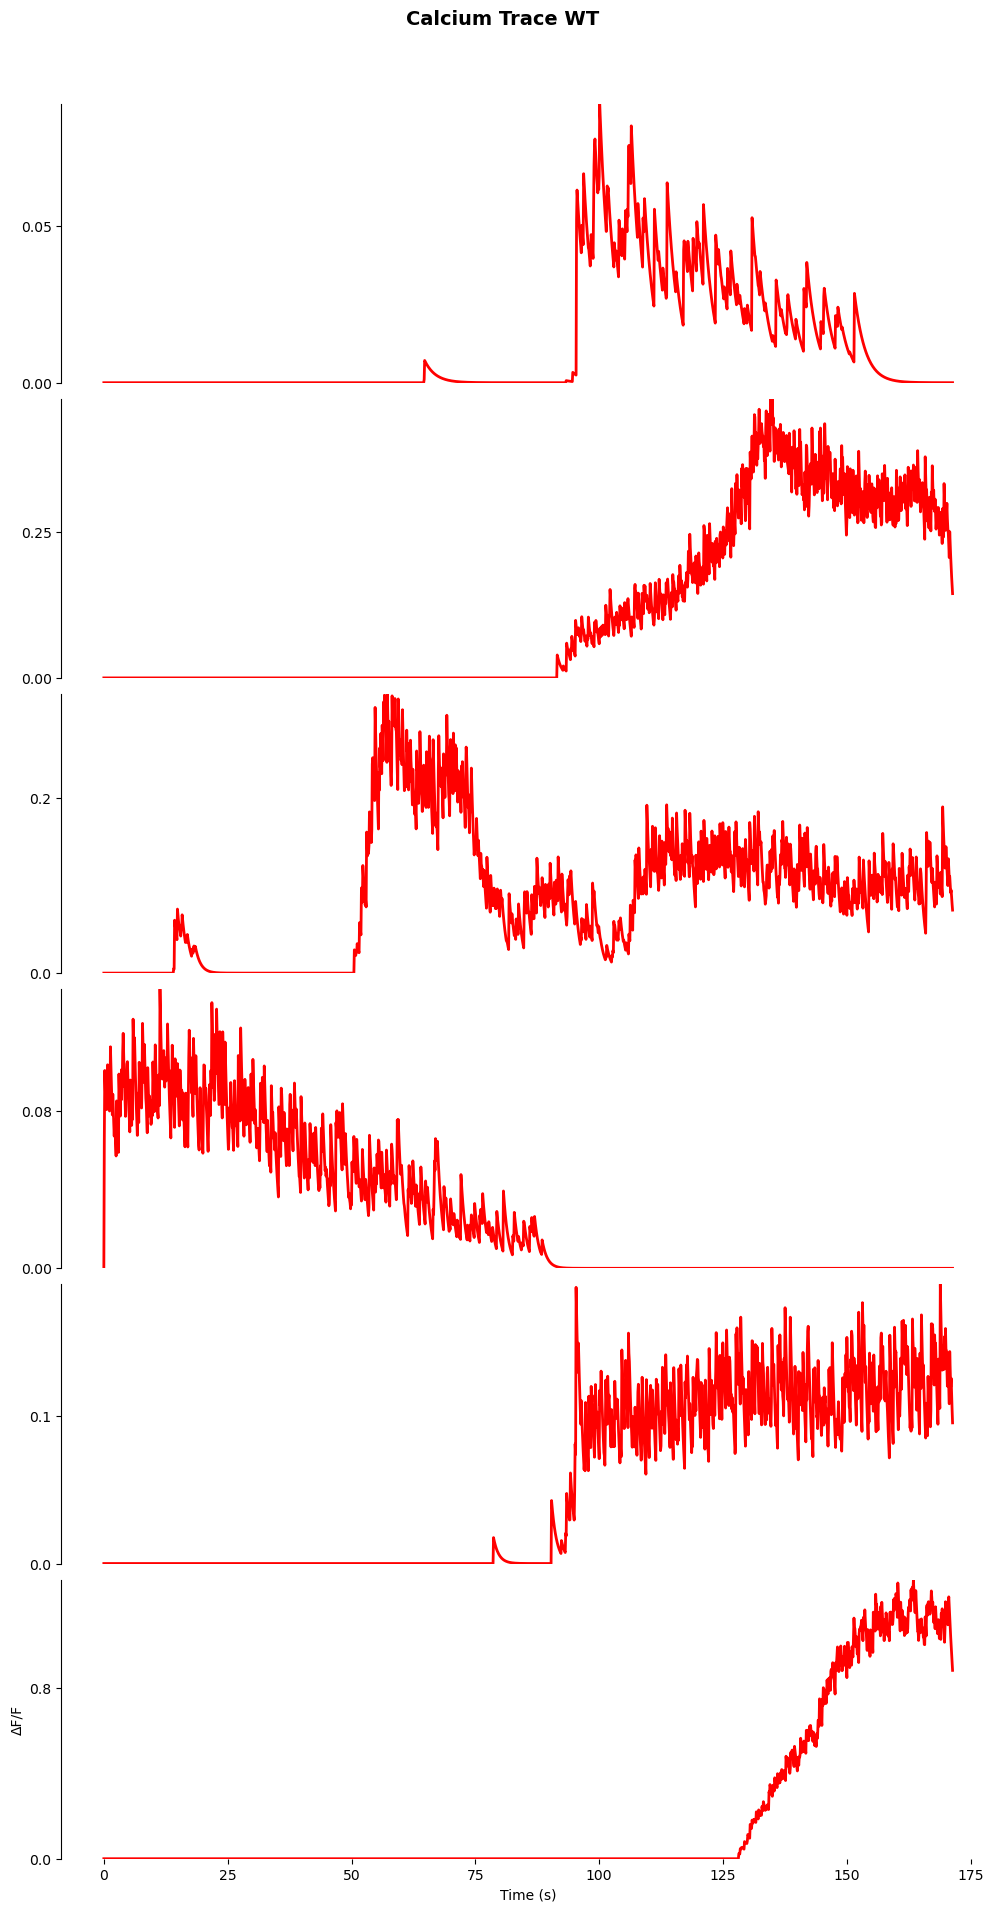

In [4]:
# set the frame rate and time per frame
frame_rate = float(input('frame rate: (default: 10.5)') or 10.5)  # Hz
time_per_frame = 1 / frame_rate  # seconds

all_time = len(time_stamps) * time_per_frame

# x value set to time (in second)
x = [i * time_per_frame for i in range(len(data))]

# setup plot
tracemap = plt.figure(figsize=(10, 20))  # adjust the height if needed

# plot every subplots
for i, column in enumerate(data.columns):
    ax = plt.subplot(len(data.columns), 1, i+1)
    
    # calculate ymax, ymin for every plot
    y_max = data[column].max()
#     y_max = 4 # 20250908 same df/f max value for better comparison
    y_min = data[column].min()
    
    ax.plot(x, data[column], color='red', linewidth=2) # trace color (e.g. NT:black, KO:red)
    ax.set_ylim(y_min, y_max)  # use range of y in subplot
    ax.yaxis.set_major_locator(plt.MaxNLocator(2))
#     ax.set_title(column, loc='left')
    # Remove the border and title except the y-axis of each graph
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    

    # remove x-axis title for every plot except the bottom one
    if i < len(data.columns) - 1:
        ax.xaxis.set_visible(False)
    else:
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('ΔF/F')

# add the main title
plt.suptitle('Calcium Trace ' + genotype, fontsize=14, fontweight='bold')

# tight_layout and show
plt.tight_layout(pad=0.54, rect=[0, 0.03, 1, 0.95])
plt.show()
tracemap.savefig(genotype+"_trace.eps", format='eps')

### 2 Frequency

### Effect of Adjusting Parameters

Adjusting `slope_window`, `valley_window`, and `detect_window` will affect peak detection in different ways:

1. **`slope_window` (slope window size)**

   * Determines how many data points are used to calculate the average slope near a peak.
   * **Larger values** → smoother slope calculation, less sensitive to noise, but may miss small peaks.
   * **Smaller values** → more sensitive to small signal changes, may detect more peaks, but higher risk of false detections from noise.<br><br>

2. **`valley_window` (valley window size)**

   * Defines the range after a peak to search for the lowest point (valley).
   * **Larger values** → can detect wide peaks and valleys, but risk linking distant unrelated valleys.
   * **Smaller values** → restricts search range, may miss wide peaks, but reduces false associations.<br><br>

3. **`detect_window` (detection window size)**

   * Ensures only one peak is detected within a specified range.
   * **Smaller values** → more permissive, may detect multiple nearby peaks (useful for fast-changing signals).
   * **Larger values** → increases minimum distance between peaks, avoids multiple detections, but may miss valid peaks.

### Practical Notes

* Parameter tuning depends on **signal characteristics** and **analysis goals**.
* Often requires **trial and error**: test on multiple signals, check detection quality, and adjust accordingly.
* Different signal types or analysis purposes may need **different parameter settings**.


In [ ]:
def calculate_slope(signal, pertime):
    return np.gradient(signal, pertime)  # get the slope in a short time period

def detect_peaks(signal, frame_rate, detect_window, valley_window, slope_window=5):   
    # slope in the signal
    slope = calculate_slope(signal, 1/frame_rate)

    # calculate slope threshold
    slope_threshold = max(np.percentile(slope, 90), np.max(slope) * 0.2)


    # calculate signal threshold
    threshold_x = np.max(signal) * 0.4

    # find peaks (local maximum value using scipy find_peaks)
    peaks, _ = find_peaks(signal, distance=detect_window)
#     peaks, _ = find_peaks(signal)
    valid_peaks = []   

    for peak in peaks:
        # make sure there is enough data around the peak to calculate slope
        if peak >= slope_window // 2 and peak <= len(signal) - (slope_window // 2) - 1:
            # calculate average slope to the left of the peak
            left_slope = np.mean(slope[max(0, peak - (slope_window // 2)):peak])

            # check if the peak meets both signal and slope conditions
            if signal[peak] > threshold_x and left_slope > 0:  # ideally > slope_threshold, but 0 works better for this dataset
                # find the lowest point within valley_window after the peak
                valley_end = min(peak + valley_window + 1, len(signal))
                min_valley_point = np.min(signal[peak + 1:valley_end])

                # check if the lowest point meets the condition
                if min_valley_point < threshold_x:
                    # within detect_window, keep only the most prominent peak
                    detect_start = max(0, peak - detect_window // 2)
                    detect_end = min(peak + detect_window // 2 + 1, len(signal))
                    if peak == np.argmax(signal[detect_start:detect_end]) + detect_start:
                        valid_peaks.append(peak)

    # return valid peaks, signal threshold, slope array, and slope threshold
    return valid_peaks, threshold_x, slope, slope_threshold


# adjust values of three criteria
slope_window = 10      # slope window size: used to calculate average slope near peaks (try 5 or 10)
valley_window = 180    # valley window size: range to search for the minimum after a peak (larger = more relaxed)
detect_window = 100    # detection window size: ensures only one peak is marked in this range (smaller = more relaxed)


frame_rate = 10.5
# calculate time per frame (in second)
time = np.arange(len(data)) / frame_rate

# initialize peak_counts for counting peaks in every ROI
peak_counts = []

for i, signal in enumerate(data.columns):
    signal_data = data[signal].astype(float)
    valid_peaks, threshold_x, slope, slope_threshold = detect_peaks(signal_data, frame_rate, detect_window, valley_window, slope_window)
    
    # peak_counts list
    peak_counts.append(len(valid_peaks))
    
    # plot all data in each row of dataframe
    plt.figure(figsize=(10, 5))

    # plot the signal and tagged the peak
    plt.subplot(2, 1, 1)
    plt.plot(time, signal_data, label='Signal')
    plt.plot(time[valid_peaks], signal_data[valid_peaks], "x", label='Peaks')  # tags on specific timing of peaks
    plt.axhline(y=threshold_x, color='r', linestyle='-', label='Threshold (thre_x)')
    plt.title(f"Cell {i} Signal with Peaks")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Signal')
    

    # plot the slope
    plt.subplot(2, 1, 2)
    plt.plot(time, slope, label='Slope')
    plt.axhline(y=slope_threshold, color='g', linestyle='--', label='Slope Threshold')
    plt.title(f"Cell {i} Slope")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Slope')
    

    plt.tight_layout()
    plt.show()


In [ ]:
print(peak_counts)
print(threshold_x)

df_peak_counts = pd.DataFrame(peak_counts)
df_peak_counts.to_csv(genotype + data_num + "peak_counts.csv")

### Plotting frequency

In [ ]:
peak_counts = np.array(peak_counts)   # peak_counts was list type

# check total_time_seconds to calculate avg freqency
# total_time_seconds = time_stamps[-1]
# time_stamps feels kinda strange so I changed to all_time :P by HY

# calculate frequency (Hz)
cell_frequencies_Hz = peak_counts / all_time

# calculate average freq
average_frequency_Hz = np.mean(cell_frequencies_Hz)

# scatter plot and barplot for avg freq
plt.figure(figsize=(2, 6))

# seperate the dots in the graph
x_random_offsets = np.random.rand(len(cell_frequencies_Hz)) * 0.8 - 0.4
x_values = np.ones(len(cell_frequencies_Hz)) + x_random_offsets
plt.scatter(x_values, cell_frequencies_Hz, alpha=0.6, facecolors='none', edgecolor='black', linewidth=2)

# bar graph for average frequency
plt.bar(1, average_frequency_Hz, width=1.8, edgecolor='black', facecolor='none', linewidth=1)

# calculate SEM
std_dev_frequencies_Hz = np.std(cell_frequencies_Hz, ddof=1)
n_frequencies_Hz = len(cell_frequencies_Hz)
sem_frequencies_Hz = std_dev_frequencies_Hz / np.sqrt(n_frequencies_Hz)

# add SEM error bar
plt.errorbar(1, average_frequency_Hz, yerr=sem_frequencies_Hz, fmt='none', color='black', capsize=5)


# setting title and axis label
plt.title('Frequency Distribution of Cells')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Nontarget')
plt.xticks([])  # Hides x ticks
plt.ylim(0, np.max(cell_frequencies_Hz) + 0.2)  # leave enough space in y axis


plt.tight_layout()
plt.show()

In [ ]:
print (cell_frequencies_Hz)

df_cell_frequencies_Hz = pd.DataFrame(cell_frequencies_Hz)
df_cell_frequencies_Hz.to_csv(genotype + data_num +"cell_frequencies_Hz.csv")

### 3 Amplitude

The function `calculate_amplitudes` is used to compute the amplitude of each peak in a given signal.

* For each signal (row/column in the dataset):
  1. Detect peaks.
  2. Detect valleys (found by inverting the signal).
  3. For each peak, calculate its amplitude as the absolute difference between the peak and its nearest valley.
* Finally, the function returns the amplitudes of all peaks across all signals.

In [ ]:
def calculate_amplitudes(signals, frame_rate):
    average_amplitudes_all_signals = []  # a list for avg amplitude of each ROI
    for column in signals:
        signal = signals[column].values  # get the signal in row

        # find the peak in ROI through the video
        peaks, _, _, _ = detect_peaks(signal, frame_rate, detect_window, valley_window, slope_window)

        # find the valley using negative value of thesignal
        valleys, _ = find_peaks(-signal)

        amplitudes = []
        for peak in peaks:
            # find every valley before the peak
            # codes after *and* prevent amplitude underestimation due tonoise-related valley
            previous_valleys = [valley for valley in valleys if valley < peak and signal[valley] <= threshold_x] 
            
            if previous_valleys:
                nearest_valley = previous_valleys[-1]  # closest valley
                amplitude = np.abs(signal[peak] - signal[nearest_valley])  # calculate amp
                amplitudes.append(amplitude)

        # calculate average amplitude for ROI if it exists and append to result
        if amplitudes:
            average_amplitude = np.mean(amplitudes)
            average_amplitudes_all_signals.append(average_amplitude)
        else:
            average_amplitudes_all_signals.append(0)  # return 0 if no amplitude applicable

    return average_amplitudes_all_signals

# calculate avg amplitude for each ROIs
amplitudes = calculate_amplitudes(data, frame_rate)

average_amplitude = np.nanmean(amplitudes)  # average amplitude
std_amplitude = np.nanstd(amplitudes)   # SD for amplitude

# Visualizing
plt.figure(figsize=(2, 6))

# scatter plot for individual amplitude
offsets = np.random.rand(len(amplitudes)) * 0.8 - 0.4
x_values = np.ones(len(amplitudes)) + offsets
plt.scatter(x_values, amplitudes, alpha=0.6, facecolors='none', edgecolor='black', linewidth=2, label='Individual Amplitudes')

# bar graph for average amplitude
plt.bar(1, average_amplitude, width=1.0, edgecolor='black', facecolor='none', linewidth=1)

# calculate SEM
std_dev_amplitude = np.std(amplitudes, ddof=1)
n_amplitude = len(amplitudes)
sem_amplitude = std_dev_amplitude / np.sqrt(n_amplitude)

# add SEM error bar
plt.errorbar(1, average_amplitude, yerr=sem_amplitude, fmt='none', color='black', capsize=5)


plt.ylabel('Amplitude')
plt.xlabel('Nontarget')
plt.xticks([])   # Hides x ticks

plt.tight_layout()
plt.show()

In [ ]:
print(amplitudes)

# save amplitudes to csv for further statistics
df_amplitudes = pd.DataFrame(amplitudes)
df_amplitudes.to_csv(genotype + data_num +"amplitudes.csv")

### 4-1 Plotting heat map(no z score)

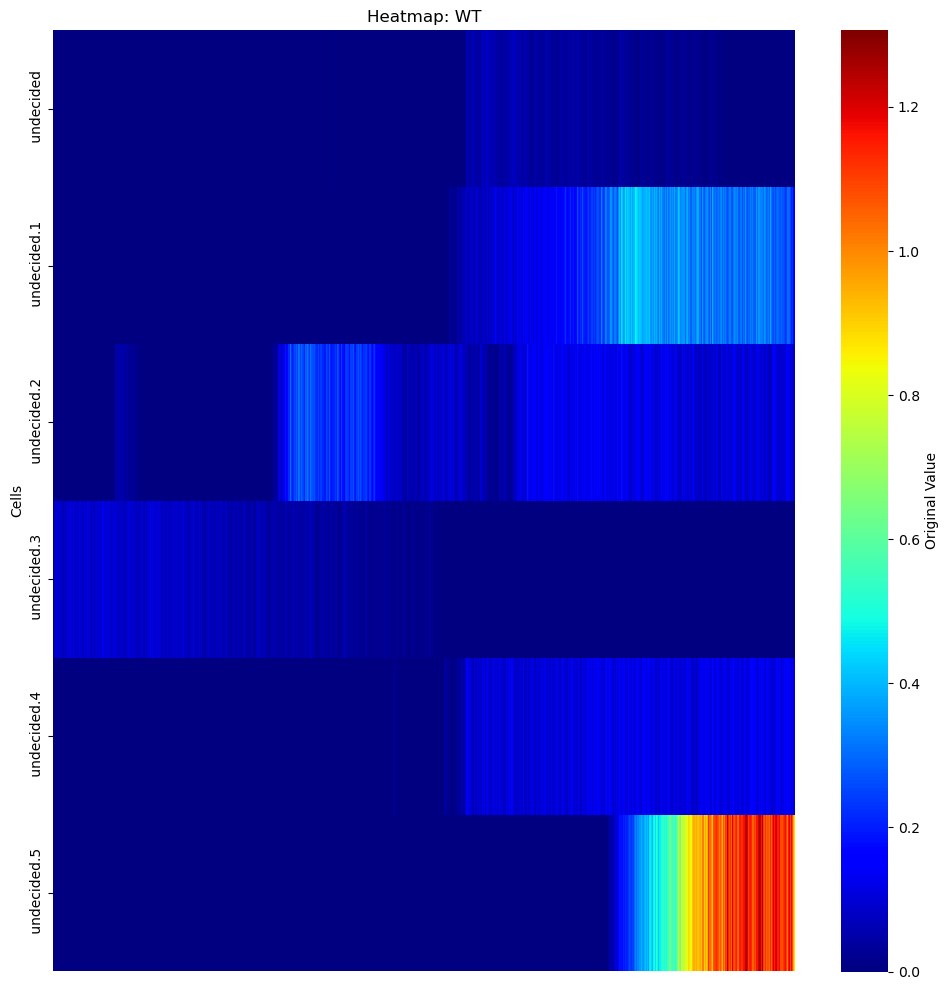

In [5]:
# heatmap using raw traces
heatmap_nonZ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(data.T,
                 cmap='jet', cbar_kws={'label': 'Original Value'})

# setting title and axis label
ax.set_title('Heatmap: '+genotype)
ax.set_xlabel('')  # Removing x-axis label
ax.set_ylabel('Cells')

# Hiding the x-axis (time) ticks
ax.set_xticks([])

plt.tight_layout()
plt.show()
heatmap_nonZ.savefig(genotype+"_heatmap_nonZ.eps", format='eps')

### 4-2 Plotting heat map(with z score)

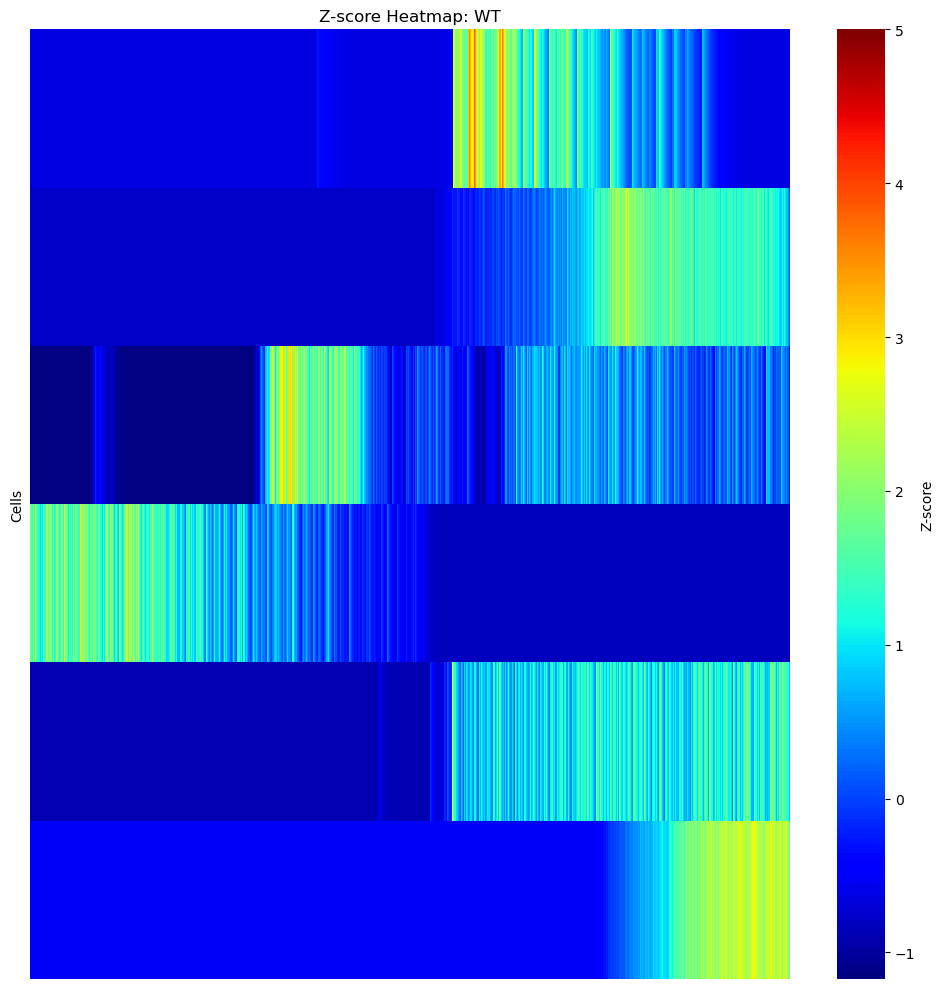

In [6]:
# calculate z score for each rows
z_scores_cleaned = (data - data.mean()) / data.std(ddof=0)

# create heatmap
heatmap_Z = plt.figure(figsize=(10, 10))
ax = sns.heatmap(z_scores_cleaned.T, vmax=5,  # vmax can set the upper bound
                 yticklabels=False,
                 cmap='jet', cbar_kws={'label': 'Z-score'})

# setting title and axis label
ax.set_title('Z-score Heatmap: ' + genotype)
ax.set_xlabel('')  # Removing the x-axis label
ax.set_ylabel('Cells')

# Hiding the x-axis (time) ticks
ax.set_xticks([])

plt.tight_layout()
plt.show()
heatmap_Z.savefig(genotype+"_heatmap_Z.eps", format='eps')

Red: Higher z-scores, indicating values significantly higher than the mean.

Blue: Lower z-scores, indicating values significantly lower than the mean.

Yellow/Green: Z-scores near zero, indicating values close to the mean.

### 5 Synchronization Index

1. **Instantaneous Phase Calculation**
   * For each cell’s signal, compute the instantaneous phase using the Hilbert transform.
   * This assigns a phase value to every time point of the signal.
   * Instantaneous phase reflects the signal’s frequency, amplitude, and phase characteristics. By applying the Hilbert transform, one can extract this information from the raw signal, capturing its cyclical dynamics at each moment. In particular, instantaneous phase describes the position of the signal within its cycle, providing a measure of its temporal properties. It is closely related to frequency and amplitude variations, and helps reveal the signal’s temporal dynamics and source behavior. <br><br>

2. **Phase Difference**
   * For each pair of signals, compute the difference in their instantaneous phases at corresponding time points.
   * This requires both signals to have the same length, or comparison only across their overlapping time points.
   * **Hilbert Transform (`hilbert(signal_data)`)**: Produces a complex representation of the signal at each time point. The real part is the original signal, and the imaginary part is its Hilbert transform. This complex representation allows the signal to be described in the complex plane, where the angle corresponds to instantaneous phase and the magnitude corresponds to instantaneous amplitude.
   * **Phase Extraction (`np.angle()`)**: Computes the angle of each complex value from the Hilbert transform, giving the instantaneous phase (ranging from -π to π). The phase angle indicates the specific position of the signal within its cycle. <br><br>

3. **Circular Variance**
   * Circular variance is used to quantify the statistical distribution of phase differences.
   * If two signals have highly consistent instantaneous phases, their phase difference will be close to zero, resulting in a low circular variance, which indicates strong synchrony.

In [ ]:
# function to calculate instantaneous phase of a signal
def calculate_instantaneous_phase(signal_data, frame_rate):
    # detect peaks in the signal (using detect_peaks defined earlier)
    peaks, _, _, _ = detect_peaks(signal_data, frame_rate, detect_window, valley_window, slope_window)
    
    # calculate instantaneous phase only if peaks are detected
    if len(peaks) > 0:
        # compute instantaneous phase using Hilbert transform
        instantaneous_phase = np.angle(hilbert(signal_data))
        unwrapped_phase = np.unwrap(instantaneous_phase)
        # adjust unwrapped phase values to range between -π and π
        normalized_phase = (unwrapped_phase + np.pi) % (2 * np.pi) - np.pi
        return normalized_phase
    else:
        # if no peaks are detected, return an empty array
        return np.array([])

# function to calculate circular variance to quantify phase synchrony between two signals
def calculate_circular_variance(phase1, phase2):
    min_length = min(len(phase1), len(phase2))  # ensure both phase arrays have the same length
    if min_length == 0:  # if one of the arrays is empty, return None
        return None
    
    # compute phase difference between the two signals (element-wise difference across time)
    phase_diff = phase1[:min_length] - phase2[:min_length]
    
    # compute circular variance of the phase differences to assess synchrony
    circular_variance = np.abs(np.mean(np.exp(1j * phase_diff)))
    return circular_variance

# calculate instantaneous phase for each signal
phases = {column: calculate_instantaneous_phase(data[column].values, frame_rate) for column in data.columns}


In [ ]:
# Choose the signals shown in the graph
signal_names = list(phases.keys())[:]

plt.figure(figsize=(15, 3))
for name in signal_names:
    plt.plot(phases[name], label=f'{name}')

plt.title('Instantaneous Phase Over Time')
plt.xlabel('Time')
plt.ylabel('Phase (radians)')
plt.legend(loc=1)
plt.show()

In [ ]:
# initialize synchronization matrix (filled with NaN)
synchronization_matrix = np.full((len(data.columns), len(data.columns)), np.nan)

# calculate synchronization index for each pair of signals and fill the matrix
for i, neuron_i in enumerate(data.columns):
    for j, neuron_j in enumerate(data.columns):
        if i == j:
            continue  # skip self-comparison
        cv = calculate_circular_variance(phases[neuron_i], phases[neuron_j])
        synchronization_matrix[i, j] = cv if cv is not None else 0

# calculate average synchronization index for each signal
synchronization_indices = np.nanmean(synchronization_matrix, axis=1)

# Calculate overall (mean) synchronization_index
mean_synchronization_index = np.mean(synchronization_indices)
mean_synchronization_index = round(mean_synchronization_index,8)

# print the result
print("Mean Synchronization Index:", mean_synchronization_index)